# Practicioners Seminar

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

## Task 2

### A correlation heatmap for currencies and equity markets

In [31]:
currencies = "FX_CHF_ALL_1971-2020.xlsx"
msci_all_local = "MSCI_ALL_LOCAL.xlsx"
df_currencies = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_msci_all_local = pd.read_excel(msci_all_local, header=3, index_col=0, sheet_name="CleanTimeSeries")



In [48]:
combined_df = pd.concat([df_currencies, df_msci_all_local], axis=1, join="inner")

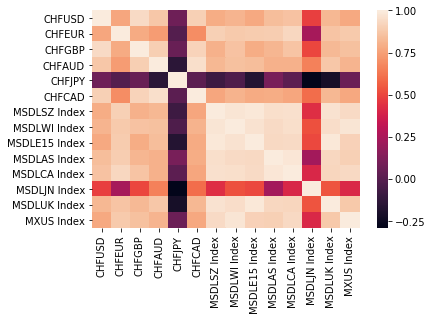

In [61]:
return_cor = combined_df.corr()
sns.heatmap(return_cor, xticklabels=return_cor.columns.values, yticklabels=return_cor.columns.values)

In [64]:
#combined_df.corr()

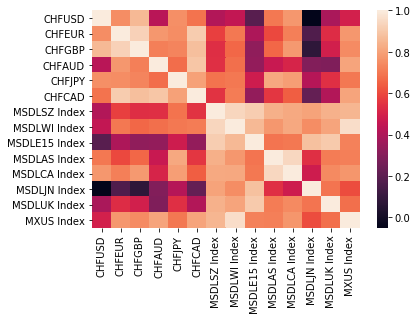

In [63]:
z=combined_df
z = z[z!=0].dropna()
sns.heatmap(z.corr(), xticklabels=z.columns.values, yticklabels=z.columns.values)